In [1]:
from __future__ import division, print_function, absolute_import
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
old_v = tf.logging.get_verbosity()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
#Training Parameters
learning_rate = 0.001
num_step = 2000
batch_size = 128

#Network Parameters
num_input = 784
num_classes = 10
dropout = 0.25

In [3]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [7]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions = pred_classes)
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.argmax(tf.cast(labels, dtype=tf.int32), 1)))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss_op, global_step = tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=tf.argmax(tf.cast(labels, dtype=tf.int32),1), 
                                  predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [8]:
#Build the Estimator
model = tf.estimator.Estimator(model_fn)

In [9]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_step)

In [11]:
#Evaluate
#Define input function for evaluation
input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images':mnist.test.images}, y = mnist.test.labels,
    batch_size = batch_size, shuffle = False)

model.evaluate(input_fn)

{'accuracy': 0.9863, 'loss': 0.04632817, 'global_step': 2000}

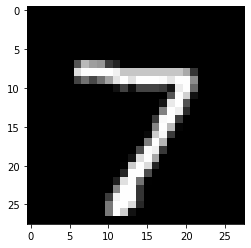

Prediction:  7


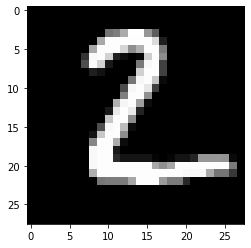

Prediction:  2


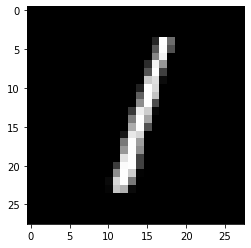

Prediction:  1


In [13]:
n_images = 3
test_images = mnist.test.images[:n_images]

input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images':test_images}, shuffle = False)

preds = list(model.predict(input_fn))

#Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap = 'gray')
    plt.show()
    print("Prediction: ", preds[i])